## Deep Learning - Creating a Bear Classifier

This document will show the step by step process that was undertaken to create a bear classifier. It identifies three types of bears that we've used as our dataset: brown bears, polar bears, and black bears.

First, let's pull the necessary libraries and imports needed

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
import requests
import json
from fastbook import *
from fastai.vision.widgets import *

### Gathering Data

Data is the core foundation of every model. It is used to train and allow the model to determine what type of data it is going to expect in the future. There are plenty of ways to gather data and they rely on what use cases you have in mind. For our example, we simply need to get a list of images from the net of the three type of bears that we need as a dataset.

I've gathered my data from here: http://www.image-net.org/. Just use a keyword and search. You should be able to see a download option for a link of urls.

Since we're dealing with text files filled with urls, I need to download those images and place them inside some sort of persistent storage. Note: I'm using Paperspace Gradient, consult the documentation of the service that you're using to determine where to store your data.

In [8]:
bears = ['black_bears', 'brown_bears', 'polar_bears']
# Holder to contain the list of urls for our bear types
holder = {
    'black_bears': [],
    'brown_bears': [],
    'polar_bears': [],
}

for bear_file in bears:
    with open(bear_file+'.txt') as fp:
        lines = fp.readlines()
        for line in lines:
            holder[bear_file].append(line.strip())


Create a 'bears' folder to store the subfolder for the images that are going to be downloaded from the urls list

In [10]:
# No need to run this if you already have a 'bears' folder in the current directory
path = Path('bears')
path.mkdir()

Finally, we'll use that path variable; create the subfolders and then download the images inside of the holder dictionary to the respective bear type.

In [12]:
for o in bears:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    download_images(dest, urls=holder[o])


 Download of http://stockpix.com/images/73720.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p bears/brown_bears
$ cd bears/brown_bears
$ wget -c http://stockpix.com/images/73720.jpg
$ tar xf 73720.jpg
 And re-run your code once the download is successful



Let's check the contents of one of the folder to verify if the download was successful

In [13]:
Path('bears/brown_bears').ls()

(#143) [Path('bears/brown_bears/00000121.jpg'),Path('bears/brown_bears/00000125.jpg'),Path('bears/brown_bears/00000143.jpg'),Path('bears/brown_bears/00000008.jpg'),Path('bears/brown_bears/00000098.jpg'),Path('bears/brown_bears/00000044.jpg'),Path('bears/brown_bears/00000041.jpg'),Path('bears/brown_bears/00000073.jpg'),Path('bears/brown_bears/00000088.jpg'),Path('bears/brown_bears/00000002.jpg')...]

Now that we've identified the download of images, we also need to clean the data from corrupt images. We're just going to use our for loop again over the three subfolders and verify the images.

In [15]:
path = Path('bears')
for bear in bears:
    dest = (path/bear)
    fns = get_image_files(dest)
    failed = verify_images(fns)
    # Unlink/remove those corrupt images from our folder
    failed.map(Path.unlink)

### Dataloaders

Dataloaders are what makes our data usable for the model. 

In [31]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(120))

I won't be going too much in depth regarding the code above since this site (https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb) provides a better explanation as to what this serves.

But to simplify it, the DataBlock defines what we require from our download data:
    * What kind of data we are working with
    * How to get the list of items
    * How to label those items
    * How to create the validation set

The DataBlock object is now created and this allows us to create a template for our dataloaders. Let's specify we're we can find the collection fo data.

In [19]:
dls = bears.dataloaders(path)

We can verify that the dataloader has our data by running the code below

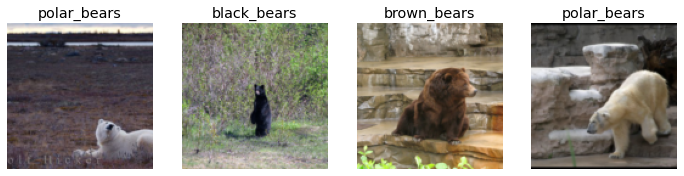

In [21]:
dls.valid.show_batch(max_n=4, nrows=1)

From the images above, we can see that each of it has a label at the top identifying what type of bear it is. This is the y-axis parameter that we passed in our DataBlock object.

There are plenty of ways to configure our dataloader to handle diffent use cases when handling data. As seen below.

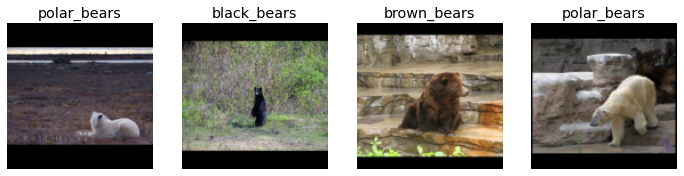

In [22]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

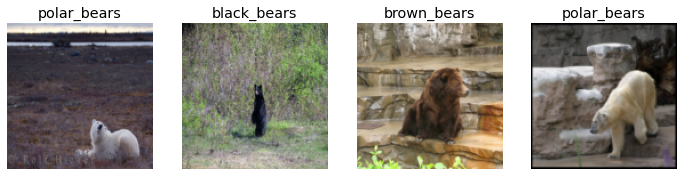

In [23]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

The problem that arises from this transformations of data, is that it gives our model an unrealistic view of what the real output is. It leads the model into thinking that things look different as to how they actually are. Because if we stretch or place paddings in our images the model will then begin taking these as part of the images itself and will lead to inaccurate results.

### Data Augmentation

Based on our the sources that we've read, *Data Augmentation* refers to creating variations of our input data, such that they appear to be different, but do not change the meaning of the data. Examples include rotation, flipping, perspective warping, brightness changes and contrast changes.

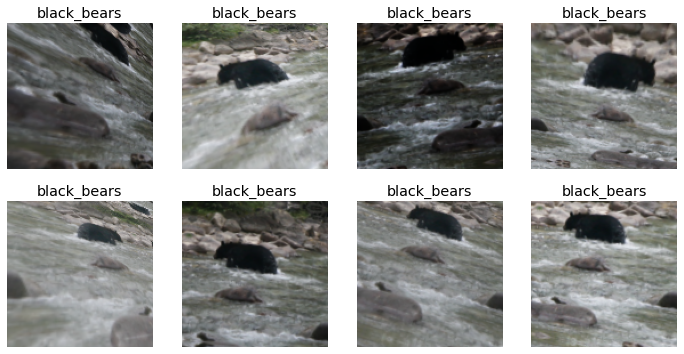

In [24]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Training the model

Now that we have some understanding of how dataloaders work. Let's use the same line of code to train our classifier.
Let's create a new dataloader with an item transform and data augmentation method that we saw earlier.

In [25]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

Now that we've ran the code above, let's create our learner and fine-tine. *Fine-tune* is basically training the model in ML terms.

In [27]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.792990,0.796795,0.272727,00:02


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.882482,0.415659,0.163636,00:02
1,0.665827,0.159241,0.072727,00:02
2,0.518306,0.090392,0.054545,00:02
3,0.409113,0.077077,0.036364,00:02


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: U

As you see, with each epoch (a run through of all images), the error_rate decreases. Let's see where our model was making mistakes. We can display this in a confusion matrix.

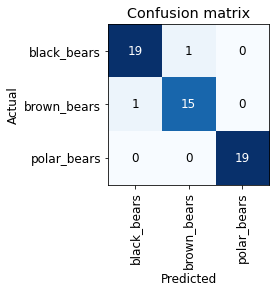

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

From the matrix, you can see that the our model had problems predicting 1 brown bear and 1 black bear. We can identifiy where this loss occured by plotting the top losses that our model has.

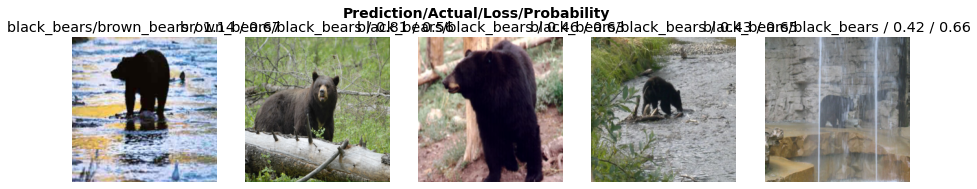

In [29]:
interp.plot_top_losses(5, nrows=1)

Knowing this information, we can also run a cleaner so we can manually identify what label each images are and help clean the data identified by our model.

In [30]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Once we've tagged that data that we need to corrected, kept, or deleted. We will need to run the following code to confirm our actions.

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

### Using model for inference

Once we're satisified with our model, we need to save it and export it to something usable. 
We can call the 'export' method, fastai will save the file to 'export.pkl'

In [32]:
learn.export()

Let's see if the file was exported

In [33]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Finally we can loader our learner for inference and pass it an image to predict.

In [3]:
learn_inf = load_learner(path/'export.pkl')

NameError: name 'load_learner' is not defined

In [ ]:
learn_inf.predict('images/grizzly.jpg')

### Creating a notebook app from the model

fastai also has a library for widgets to be used in a notebook for a more user-friendly way of using our classifier.

The code below basically initializes all of the components that we are going to use for our widget box.

In [2]:
out_pl = widgets.Output()

lbl_pred = widgets.Label()

btn_run = widgets.Button(description='Classify')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()   

NameError: name 'widgets' is not defined

Create the container for our widgets.

In [1]:
VBox([widgets.Label('Select your bear!'), btn_upload, btn_run, out_pl, lbl_pred])

NameError: name 'VBox' is not defined

So with the output above, we have now created an interface to use our model.

### Next steps

The next steps would be is putting our notebook app or our model in some sort of production. There are guides online and services that support this. Another thing would be to understand the disasters that could arise with using such simplified steps in a real-life scenario. We need to understand exactly the data that we require, what type of data it is, how safe it is, and how accurate would the output be. These are the things to keep in mind when creating models.

## Further reading

I highly advocate to read the contents that are found within this website to further our knowledge in using Deep Learning to train our models. https://course.fast.ai/